In [1]:
import argparse
import numpy as np
import pandas as pd
import os
import glob
import sys
import xarray as xr
import yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cmocean as cmo
import functions.common as cf
import functions.plotting as pf
import functions.hurricanes_plotting as hp
plt.rcParams.update({'font.size': 12})  # all font sizes are 12 unless otherwise specified

In [2]:
def subset_grid(ext, dataset, lon_name, lat_name):
    if len(np.shape(dataset[lon_name])) == 1:
        lonx, laty = np.meshgrid(dataset[lon_name], dataset[lat_name])
    else:
        lonx = dataset[lon_name]
        laty = dataset[lat_name]

    if dataset.name == 'TMP_P0_L1_GLL0':  # RTG dataset
        lonx[lonx > 180] = lonx[lonx > 180] - 360  # convert longitude from 0 to 360 to -180 to 180

    lon_idx = np.logical_and(lonx > ext[0], lonx < ext[1])
    lat_idx = np.logical_and(laty > ext[2], laty < ext[3])

    # find i and j indices of lon/lat in boundaries
    ind = np.where(np.logical_and(lat_idx, lon_idx))

    # subset data from min i,j corner to max i,j corner
    # there will be some points outside of defined boundaries because grid is not rectangular
    data_sub = np.squeeze(dataset)[range(np.min(ind[0]), np.max(ind[0]) + 1), range(np.min(ind[1]), np.max(ind[1]) + 1)]
    lon = data_sub[lon_name]
    lat = data_sub[lat_name]

    return data_sub, lon, lat

In [3]:
##### ARGS ######
ymd = '20181228'

save_dir = '/users/jameskim/Documents/rucool/SSTcodetest'
save_file = os.path.join(save_dir, f'ru-wrf_sst_rtg_{ymd}.png')  # Modified save_file name

yr = pd.to_datetime(ymd).year

ym = ymd[0:6]
month = pd.to_datetime(ymd).month

In [4]:
sst_inputs_dir = os.path.join('/users/jameskim/Documents/rucool/SSTcodetest', ymd)
extent_3km, __, __, __ = cf.define_axis_limits('3km')

try:
    rtg_file = glob.glob(os.path.join(sst_inputs_dir, 'rtgssthr_*.grib2'))[0]
except IndexError:
    rtg_file = 'no_file'

In [5]:
# get RTG file (file is from the previous day for the WRF input)
if rtg_file == 'no_file':
    print(f'No such file or directory: {rtg_file}')
    sst_rtg = None
else:
    ds_rtg = xr.open_dataset(rtg_file, engine='pynio')
    sst_rtg = np.squeeze(ds_rtg.TMP_P0_L1_GLL0) - 273.15  # convert K to degrees C

In [6]:
vlims = [5, 30]
cmap = cmo.cm.thermal
levels = MaxNLocator(nbins=16).tick_values(vlims[0], vlims[1])  # levels every 1 degrees C
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

In [17]:
if type(sst_rtg) == xr.core.dataarray.DataArray:
    sst_rtg_sub, lon_rtg, lat_rtg = subset_grid(extent_3km, sst_rtg, 'lon_0', 'lat_0')
else:
    sst_rtg_sub = None

Text(0.5, 0.98, 'RU-WRF RTG SST Input: 2018-12-28')

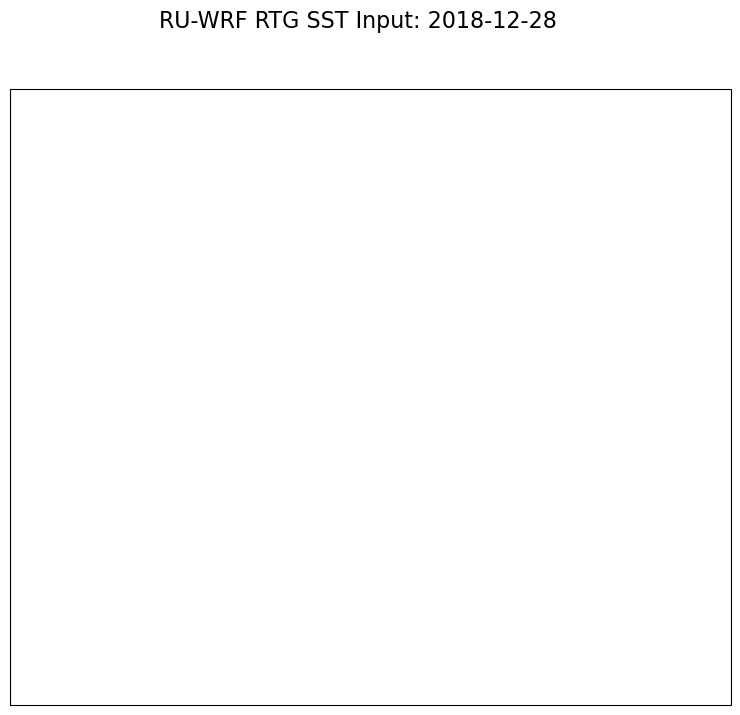

In [43]:
main_title = f'RU-WRF RTG SST Input: {pd.to_datetime(ymd).strftime("%Y-%m-%d")}'

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Mercator()))
fig.suptitle(main_title, fontsize=16, y=.98)

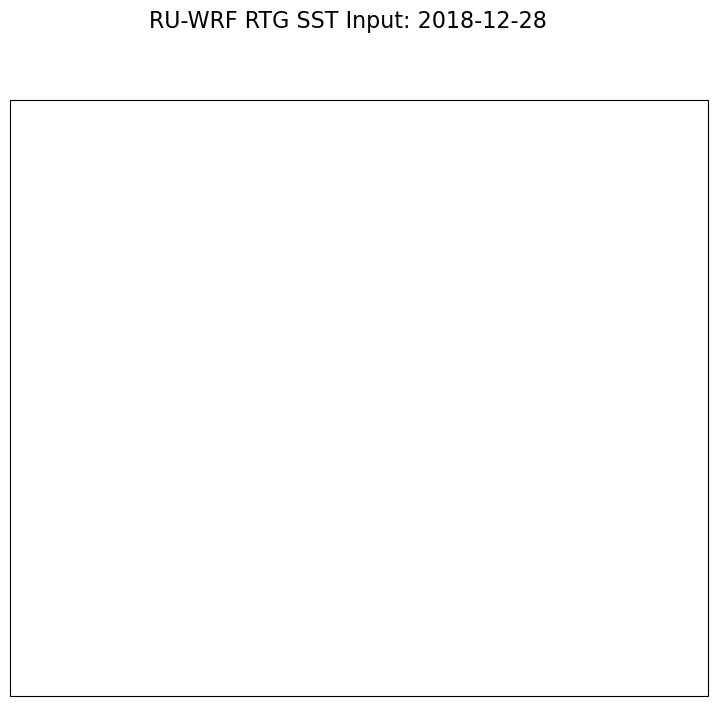

In [9]:
fig

In [51]:
kwargs = dict()
#kwargs['zoom_coastline'] = False
#kwargs['bottom_label'] = False
hp.map_create(extent_3km, ax=ax, **kwargs)
kwargs['cmap'] = cmap
kwargs['norm_clevs'] = norm
kwargs['title_pad'] = 8
kwargs['extend'] = 'both'
kwargs['clab'] = 'SST (\N{DEGREE SIGN}C)'


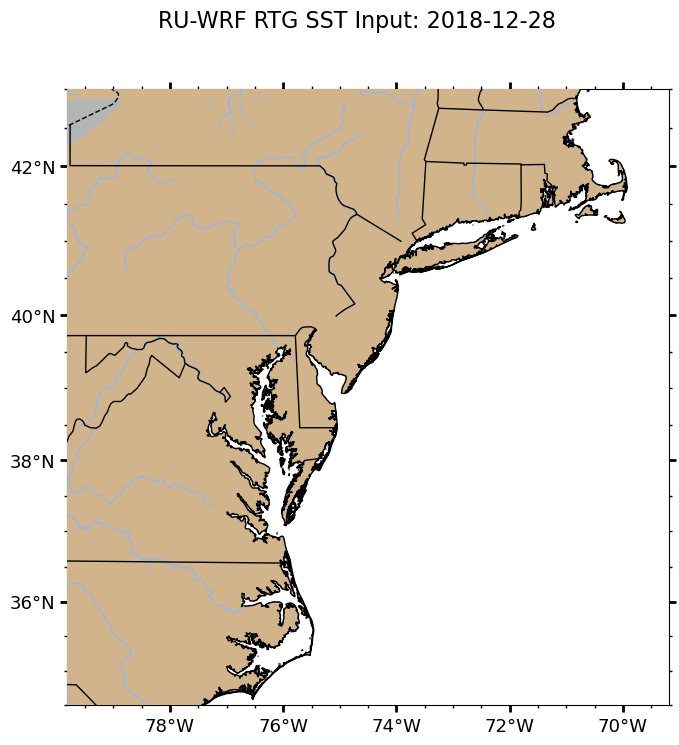

In [11]:
fig

In [52]:
contour_list = [5, 10, 15, 20, 25, 30]

if type(sst_rtg_sub) == xr.core.dataarray.DataArray:
    pf.add_contours(ax, lon_rtg, lat_rtg, sst_rtg_sub.values, contour_list)

In [53]:
if type(sst_rtg_sub) == xr.core.dataarray.DataArray:
    cplot = pf.plot_pcolormesh_panel(fig, ax, lon_rtg, lat_rtg, sst_rtg_sub.values, **kwargs)
else:
    ax.set_title(kwargs['panel_title'], fontsize=15, pad=kwargs['title_pad'])



<Figure size 640x480 with 0 Axes>

In [54]:
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.02, hspace=0.12)

<Figure size 640x480 with 0 Axes>

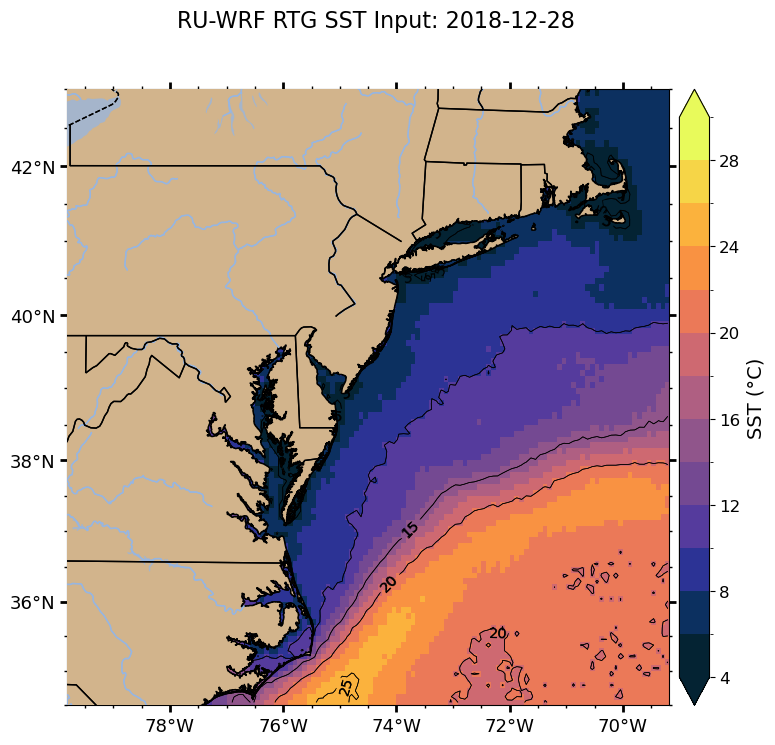

In [55]:
fig

In [34]:
plt.savefig(save_file,dpi = 200)

<Figure size 640x480 with 0 Axes>